In [14]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch
import logging
logging.basicConfig(level=logging.WARNING)
from matplotlib import cm

from visualize.reg_map import draw_reg_map

In [2]:
# default_device = "cuda"
# torch.set_default_device(default_device)

In [3]:
from turtle_id_test_config import data_path

from turtle_id_test_config import test_scalar_reg_path, test_reg_map_path

from turtle_id_test_config import data_path, upper_level
import turtle_id_test_config

# data_group = "train"
data_group = "test"

# https://wandb.ai/wof/turtle_id_2022/runs/cfbkuz9y
model_date, epoch = "06_24_19_56_05", 50

test_reg_map_results_path = f"{test_reg_map_path}/{model_date}-{epoch}/{data_group}"

model_path=f"{upper_level}/models/model-turtle_id_2022-2024_{model_date}/model_epoch_{epoch}.pt"

In [4]:
num_samples = 1 # 0 for all
# size = 256
size = 512
sigmas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# sigmas = [0.05]

In [5]:
# file_paths:dict = get_file_paths(data_path, "test", num_samples, sigmas, size)
file_paths:dict = {
    0: [f'images_crop_resize_{size}_greyscale/t008/PaXakrkxqN.JPG'],
    0.05: [f'images_crop_resize_{size}_greyscale_noisy_0_05/t008/PaXakrkxqN.JPG'],
    0.1: [f'images_crop_resize_{size}_greyscale_noisy_0_1/t008/PaXakrkxqN.JPG'],
    0.15: [f'images_crop_resize_{size}_greyscale_noisy_0_15/t008/PaXakrkxqN.JPG'],
    0.2: [f'images_crop_resize_{size}_greyscale_noisy_0_2/t008/PaXakrkxqN.JPG'],
    0.25: [f'images_crop_resize_{size}_greyscale_noisy_0_25/t008/PaXakrkxqN.JPG'],
    0.3: [f'images_crop_resize_{size}_greyscale_noisy_0_3/t008/PaXakrkxqN.JPG'],
}

In [6]:
# pprint(file_paths)

In [7]:
# file_paths is a dict with keys the sigmas and values the list of file paths
# Check that every list has the same length
for key in file_paths.keys():
    assert len(file_paths[key]) == num_samples

In [8]:
def apply_to_files(func):
    results = []
    for sigma in tqdm(sigmas):
        print(f"sigma={sigma}")
        for sample_id in tqdm(range(num_samples), 
                            #   leave=False # remove inner progress bar upon completion (as in "don't leave it there")
                              ):
            file = file_paths[sigma][sample_id]
            extension = file.split(".")[-1]
            file = file.replace(f".{extension}", "")
            res = func(file)
            if res is not None:
                results.append(res)
    return results
            

In [9]:
model = torch.load(model_path)
model.eval()

StaticImagePrimalDualNN(
  (pdhg): PDHG(
    (GradOps): GradOperators()
    (ClipAct): ClipAct()
  )
  (cnn): UNet3d(
    (c0x0): DoubleConv(
      (conv_block): Sequential(
        (0): Conv3d(1, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): Conv3d(128, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (3): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (encoder): ModuleList(
      (0): EncodeBlock3d(
        (pool): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=(0, 0, 0), dilation=1, ceil_mode=False)
        (double_conv): DoubleConv(
          (conv_block): Sequential(
            (0): Conv3d(128, 256, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
            (2): Conv3d(256, 256, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
            (3): LeakyReLU(ne

In [15]:
def get_lambda_map(file:str):
    reg_map_path = f"{test_reg_map_results_path}/{file}"
    noisy_path = f"{reg_map_path}/noisy.png"
    noisy_PIL = Image.open(noisy_path)
    noisy_np = np.array(noisy_PIL, dtype=np.float32) / 255
    noisy_2d = torch.tensor(noisy_np)
    
    noisy_5d = noisy_2d.unsqueeze(-1).unsqueeze(0).unsqueeze(0).to("cuda")
    reg_map_5d = model.get_lambda_cnn(noisy_5d)
    
    reg_map_2d = reg_map_5d[0][0].squeeze(-1)
    reg_map_np = reg_map_2d.detach().cpu().numpy()
    
    color_map = cm.magma
    
    reg_map_img = color_map(reg_map_np)
    reg_map_PIL = Image.fromarray((reg_map_img * 255).astype(np.uint8))
    reg_map_PIL.save(f"{reg_map_path}/reg_map.png")
    
    return reg_map_np

In [16]:
lambda_maps = apply_to_files(get_lambda_map)

  0%|          | 0/6 [00:00<?, ?it/s]

sigma=0.05


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.1


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.15


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.2


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.25


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.3


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
def plot_lambda_map(id_example, cut_off=0.6, offset=0.05):
    file_example = file_paths[sigmas[id_example]][0]
    print(f"Example file: {file_example}")
    example = lambda_maps[id_example]
    # Count the number of negative values
    num_neg = np.sum(example < 0)
    print(f"Number of negative values: {num_neg}")
    
    draw_reg_map(example)
    
    example_clip = np.clip(example, 0, cut_off)
    draw_reg_map(example_clip)
    
    example_log = np.log(example + offset)
    draw_reg_map(example_log)

Example file: images_crop_resize_512_greyscale_noisy_0_2/t008/PaXakrkxqN.JPG
Number of negative values: 0


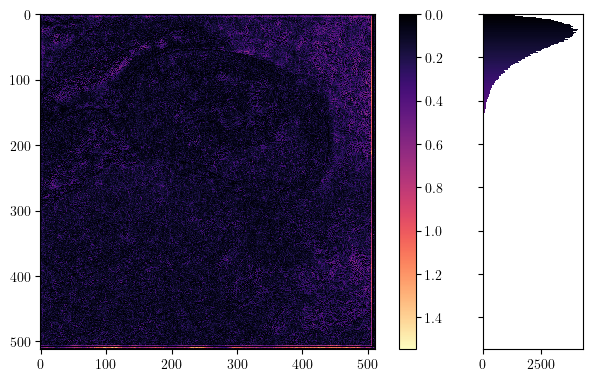

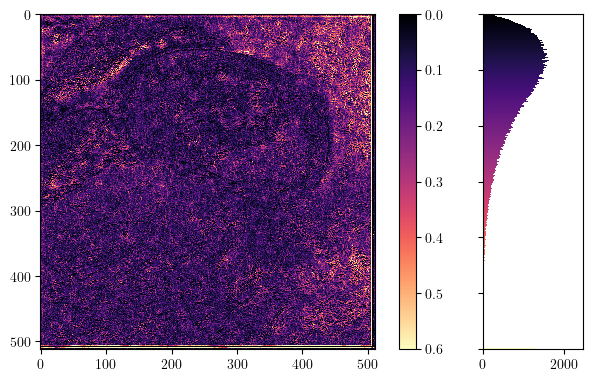

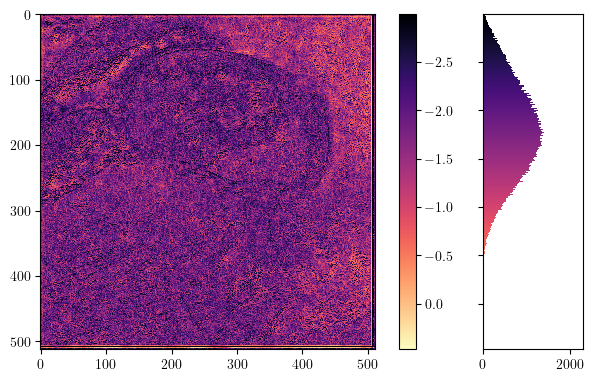

In [13]:
plot_lambda_map(3, cut_off=0.6, offset=0.05)